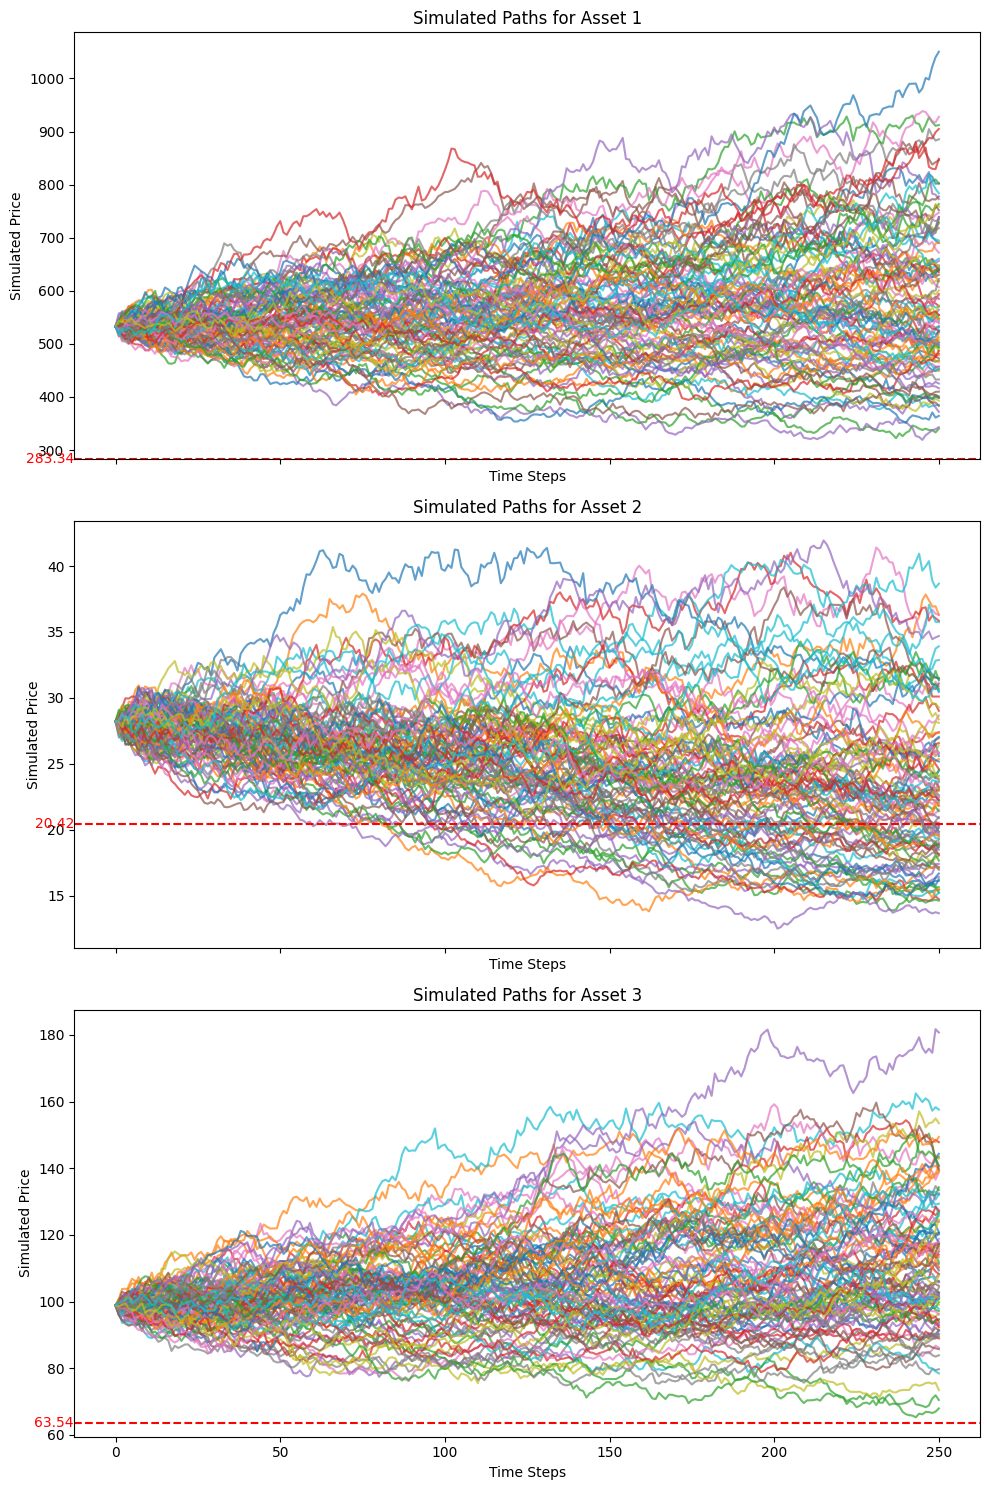

In [1]:
from GBM import MultiBS
import numpy as np

path1 = "datasets/UNH.csv"
path2 = "datasets/PFE.csv"
path3 = "datasets/MRK.csv"

multi_bs = MultiBS()

forward_simulation = multi_bs.simulate_multi_GBM_exact(T=1, M=10_000)
v, sigma = multi_bs.calibrate_model(forward_simulation)
simul = multi_bs.simulate_multi_GBM_exact(T=1, M=100)
multi_bs.plot(simul)

In [2]:
import pandas as pd
start_date="2023-08-23"

start_date = pd.to_datetime(start_date).strftime("%Y-%m-%d")
# Find the index of the start_date in the asset data
start_index = multi_bs.asset_1.loc[multi_bs.asset_1["Date"] == start_date]["Close"].index[0]

# Slice the historical data from start_date onwards
historical_prices_1 = multi_bs.asset_1["Close"].iloc[start_index:].values
historical_prices_2 = multi_bs.asset_2["Close"].iloc[start_index:].values
historical_prices_3 = multi_bs.asset_3["Close"].iloc[start_index:].values
historical_prices = np.column_stack([historical_prices_1, historical_prices_2, historical_prices_3])
historical_prices[0, :]

array([480.22924805,  34.61804962, 107.69082642])

0.9440000000000001


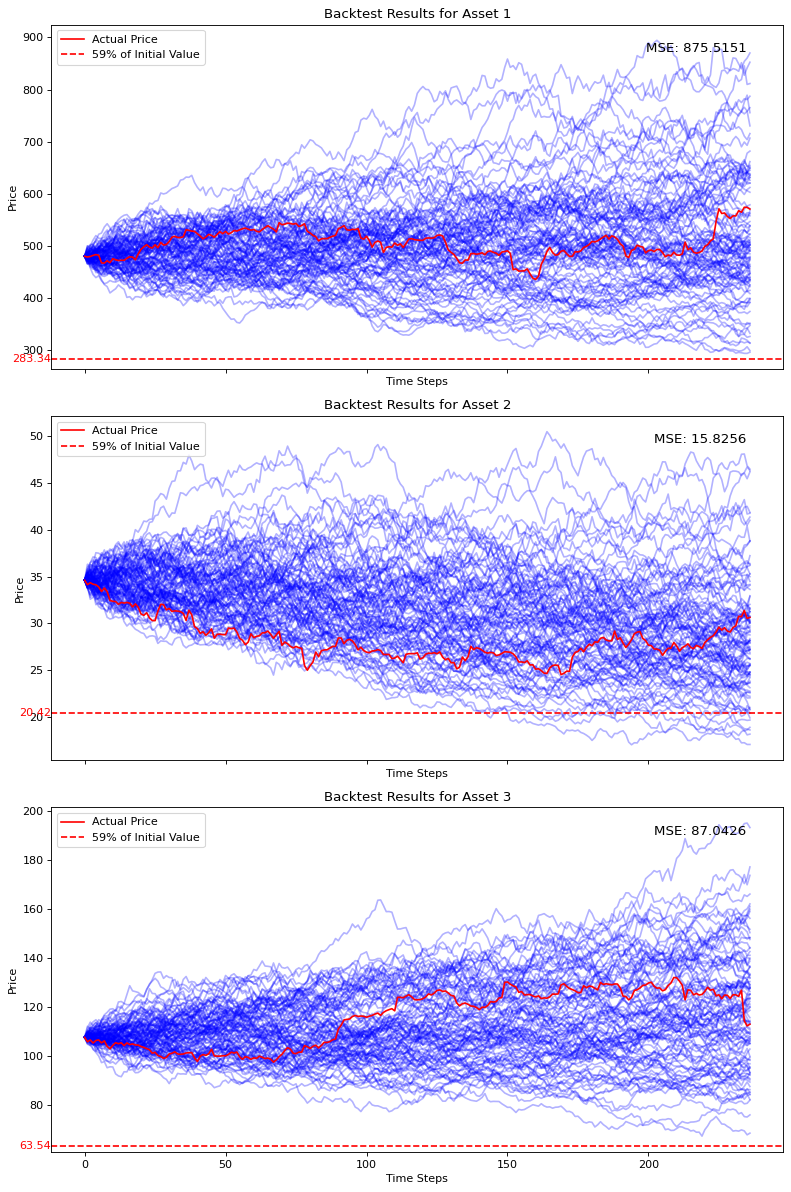

Mean Squared Error (MSE) for each asset: [875.51507911  15.82556749  87.04264586]
Root Mean Squared Error (RMSE) for each asset: [29.58910406  3.97813618  9.32966483]


array([875.51507911,  15.82556749,  87.04264586])

In [3]:
multi_bs.backtest(M=100)

0.252


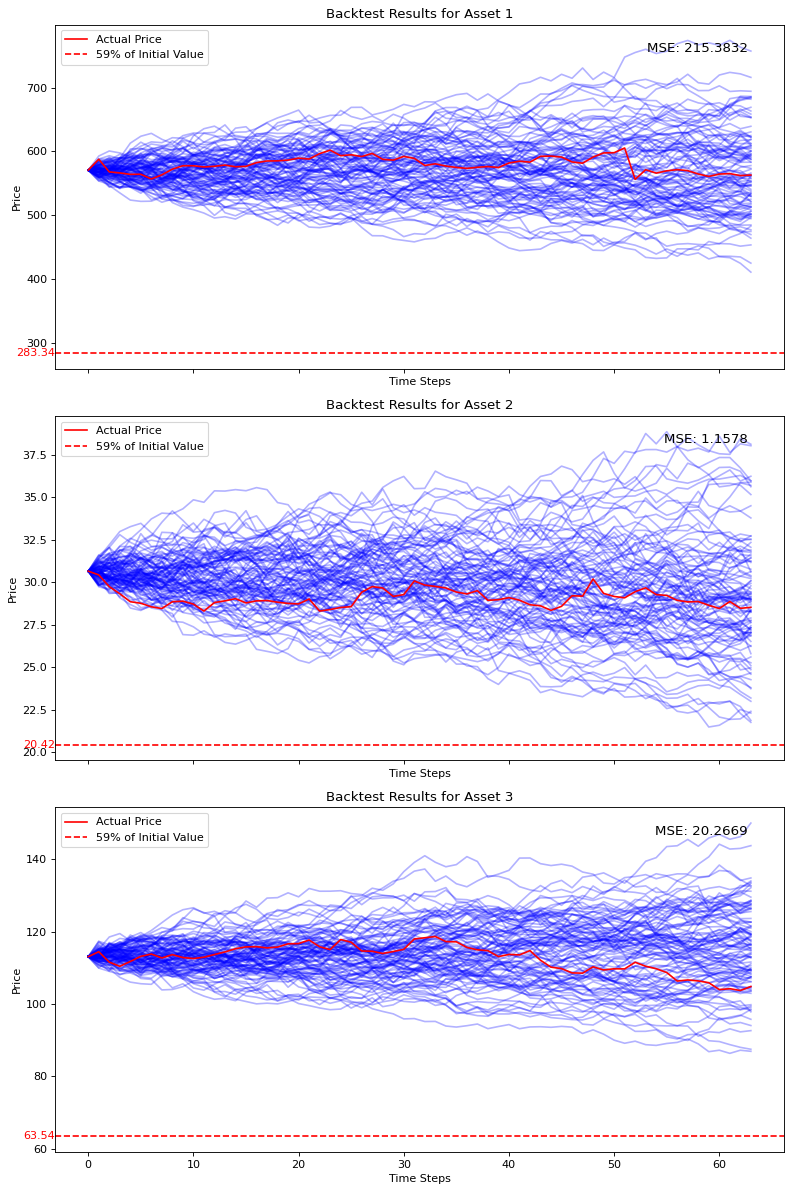

Mean Squared Error (MSE) for each asset: [215.38317488   1.15784837  20.26686967]
Root Mean Squared Error (RMSE) for each asset: [14.67593864  1.07603363  4.50187402]


array([215.38317488,   1.15784837,  20.26686967])

In [5]:
multi_bs.backtest(M=100, start_date="2024-08-01", end_date="2024-10-30")

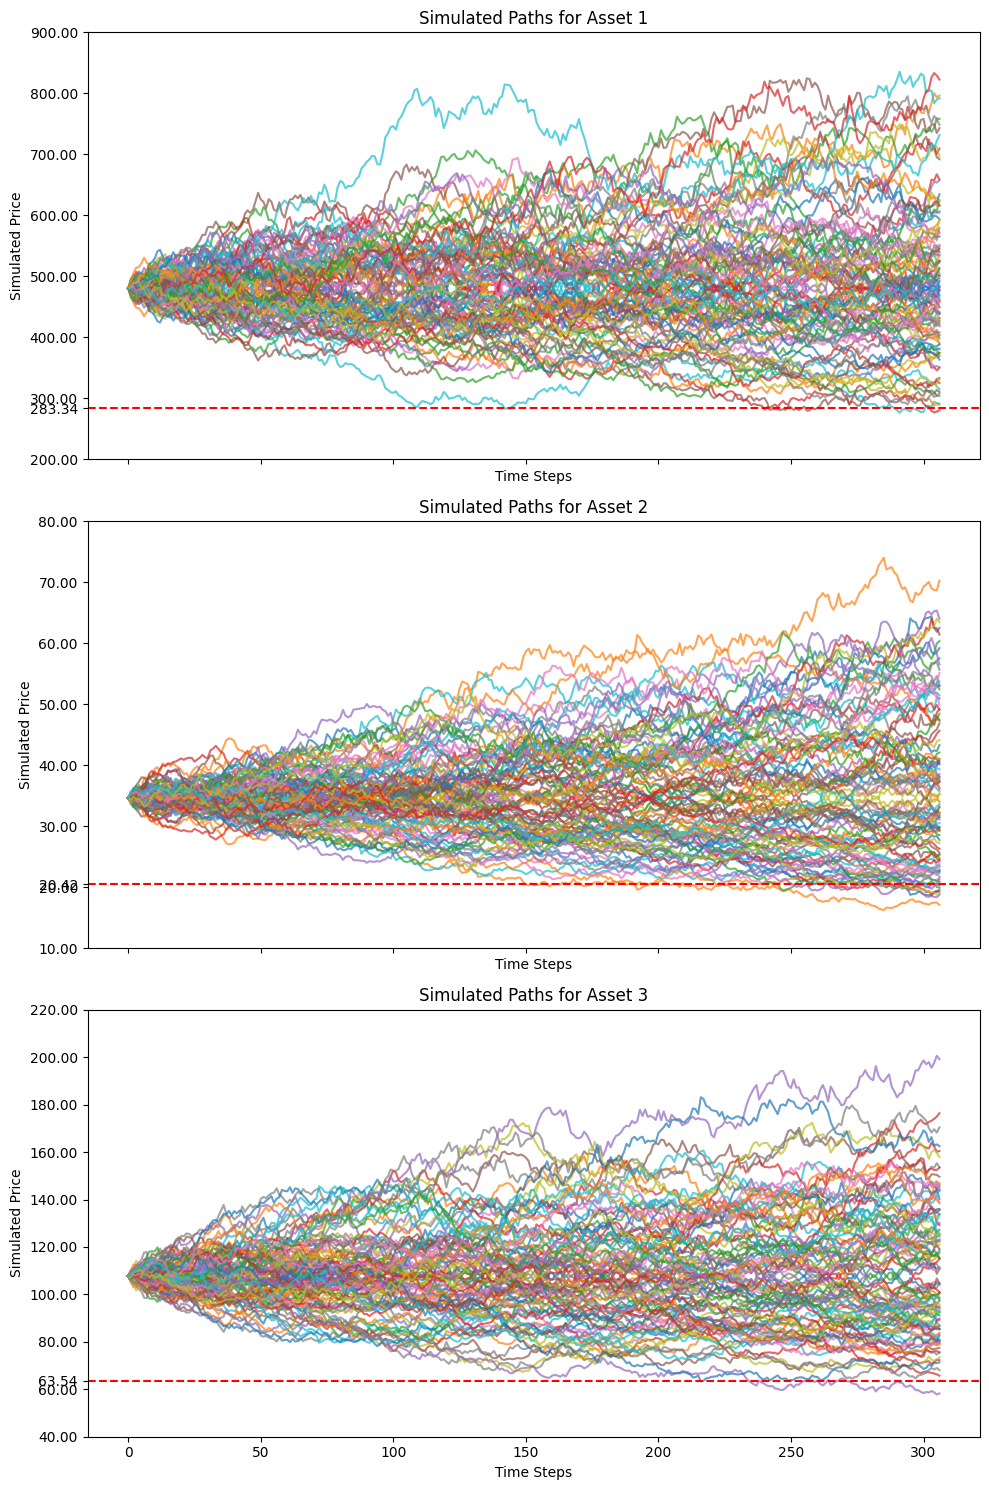

In [3]:
simul = multi_bs.simulate_multi_GBM_antithetic(T=306/250, M=100)
multi_bs.plot(simul)

In [4]:
from LSL import LSL
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lsl = LSL(multi_bs, 0, 0.04)
params = torch.tensor([[0.0041],
                        [0.0055],
                        [-0.2940],
                        [5.0],
                        [0.30470]], dtype=torch.float64).to(device).reshape(1,-1).tile(3,1)

standard_normal = torch.distributions.Normal(torch.tensor([0]).to(device), torch.tensor([1]).to(device))

uni = torch.rand((1000, 3, 317, 2))

lsl.train(0.04, multi_bs.Sigma, params, max_epochs=10)
paths = lsl.model.multi_asset_path(standard_normal.icdf(uni), uni, params, 0.04, multi_bs.Sigma)
lsl.evaluate_payoff(paths, 0.04)

Training Progress: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s, Worst loss=1, Best Loss=0.0878]  


tensor([0.2453, 0.0753, 0.2378, 0.2531, 0.2443, 0.0753, 0.2566, 0.2438, 0.0753,
        0.2576, 0.0753, 0.2430, 0.2445, 0.0753, 0.2478, 0.0753, 0.2495, 0.0753,
        0.2496, 0.2551, 0.0753, 0.0753, 0.2469, 0.0753, 0.2471, 0.2496, 0.2453,
        0.2480, 0.2470, 0.2412, 0.0753, 0.0753, 0.0753, 0.2456, 0.2631, 0.2540,
        0.0753, 0.0753, 0.2504, 0.2502, 0.0753, 0.2486, 0.2377, 0.2530, 0.2575,
        0.2429, 0.2437, 0.0753, 0.2592, 0.0753, 0.2390, 0.2426, 0.0753, 0.2334,
        0.0753, 0.2384, 0.2337, 0.2362, 0.2354, 0.0753, 0.0753, 0.2413, 0.0753,
        0.0753, 0.2374, 0.0753, 0.2588, 0.0753, 0.2413, 0.2477, 0.2481, 0.2471,
        0.0753, 0.2539, 0.0753, 0.0753, 0.0753, 0.2557, 0.2507, 0.2358, 0.2588,
        0.2397, 0.0753, 0.2562, 0.2430, 0.0753, 0.0753, 0.2523, 0.2470, 0.2501,
        0.2618, 0.0753, 0.2562, 0.2427, 0.2553, 0.2472, 0.0753, 0.0753, 0.0753,
        0.0753, 0.2431, 0.2489, 0.2582, 0.2478, 0.2418, 0.2450, 0.0753, 0.0753,
        0.0753, 0.2510, 0.2548, 0.0753, 

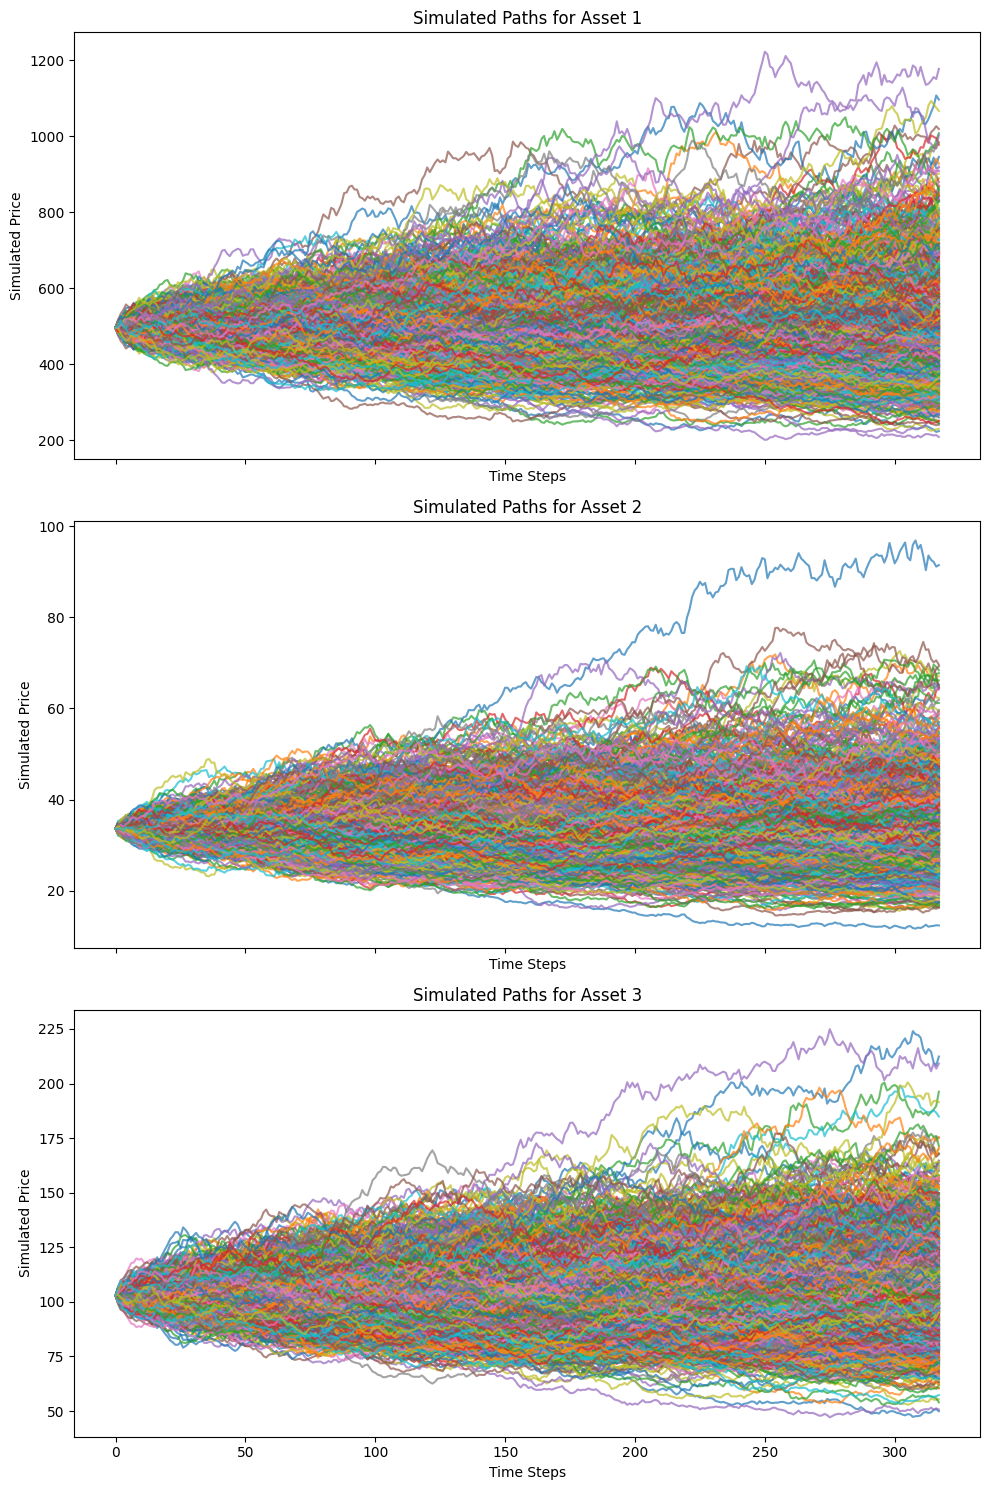

In [5]:
simul = torch.exp(paths[:,:,:,0])
simul = simul.permute(1,2,0)
multi_bs.plot(simul)

In [21]:
delta = multi_bs.calculate_delta(T=1.5, h=0.01)
gamma = multi_bs.calculate_gamma(T=1.5, h=0.01)

In [22]:
print(multi_bs.v, multi_bs.Sigma)

[-0.02757865 -0.02908197 -0.0197659 ] tensor([[0.0554, 0.0170, 0.0126],
        [0.0170, 0.0584, 0.0158],
        [0.0126, 0.0158, 0.0397]])


In [23]:
print(f"Delta: {delta}, \nGamma: \n{gamma}")

Delta: [-0.05077797 -0.18734916 -0.01286955], 
Gamma: 
[[ 0.00594985  0.17444509  0.04106891]
 [ 0.00703164 -0.14019132  0.0363978 ]
 [-0.00294624 -0.23202048 -0.01449255]]


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Generate log-spaced values for h between 0.001 and 0.05
h_values = np.logspace(-3, -1, num=1000)  # 5 values from 0.001 to approximately 0.05
T = 1.5
M = 1000
deltas = []
gammas = []

# Calculate Delta and Gamma for each h value
for h in h_values:
    delta = multi_bs.calculate_delta(T, M, h)
    gamma = multi_bs.calculate_gamma(T, M, h)
    deltas.append(delta)
    gammas.append(gamma)

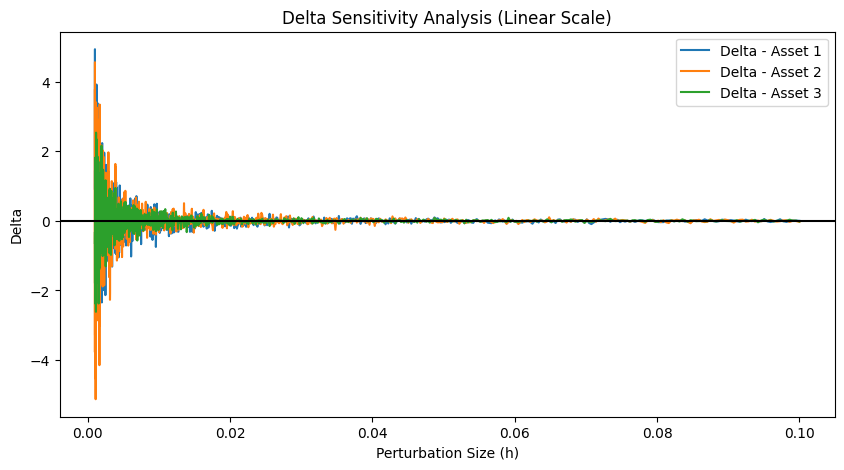

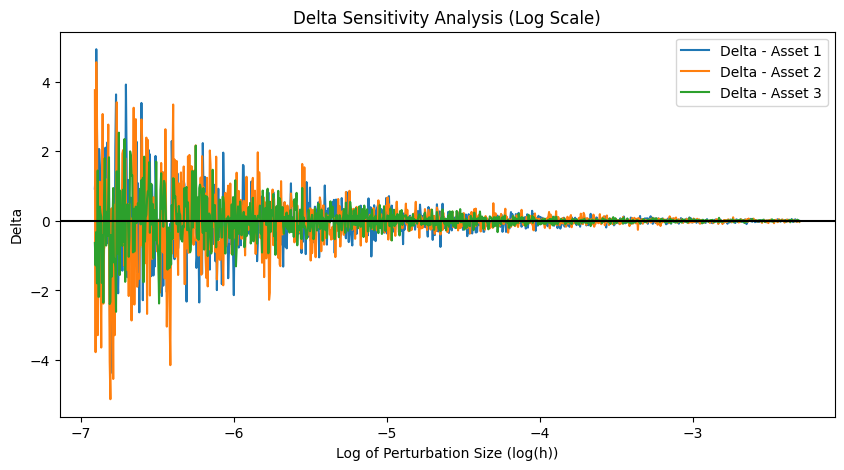

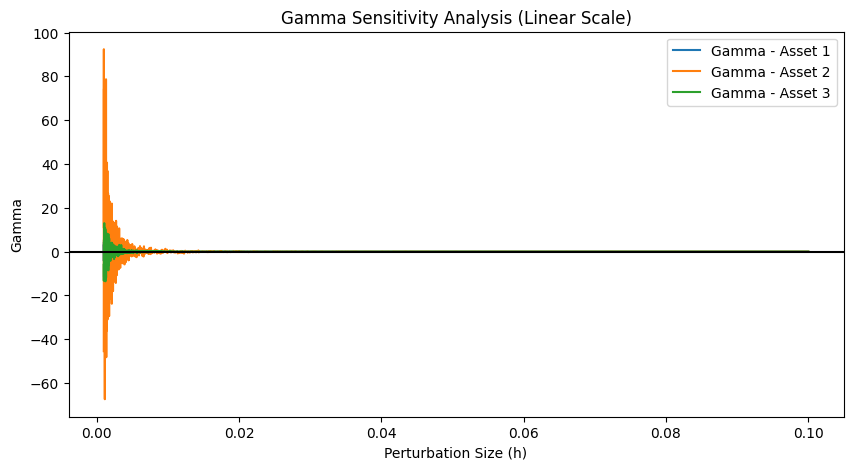

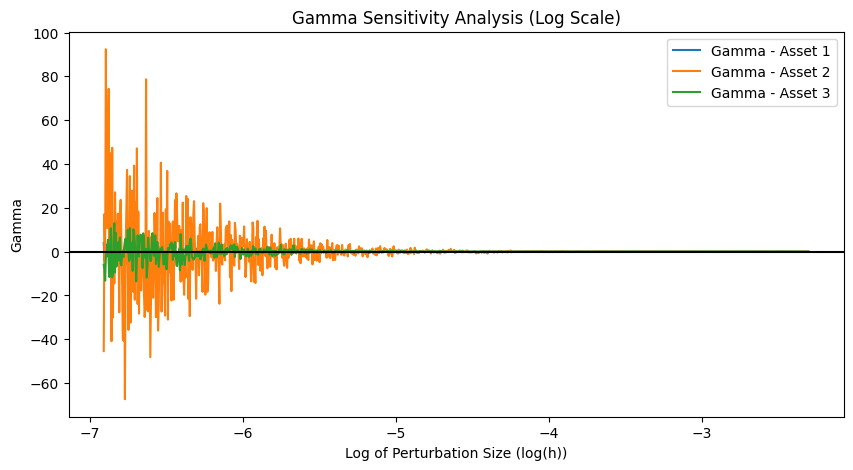

In [20]:
# Plot Delta in h scale
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(h_values, [d[i] for d in deltas], label=f"Delta - Asset {i+1}")
plt.axhline(0, color="black")

plt.xlabel("Perturbation Size (h)")
plt.ylabel("Delta")
plt.title("Delta Sensitivity Analysis (Linear Scale)")
plt.xscale("linear")
plt.legend()
plt.show()

# Plot Delta in log(h) scale
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(np.log(h_values), [d[i] for d in deltas], label=f"Delta - Asset {i+1}")
plt.axhline(0, color="black")
plt.xlabel("Log of Perturbation Size (log(h))")
plt.ylabel("Delta")
plt.title("Delta Sensitivity Analysis (Log Scale)")
plt.xscale("linear")
plt.legend()
plt.show()

# Plot Gamma (diagonal terms) in h scale
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(h_values, [g[i, i] for g in gammas], label=f"Gamma - Asset {i+1}")
plt.axhline(0, color="black")
plt.xlabel("Perturbation Size (h)")
plt.ylabel("Gamma")
plt.title("Gamma Sensitivity Analysis (Linear Scale)")
plt.xscale("linear")
plt.legend()
plt.show()

# Plot Gamma (diagonal terms) in log(h) scale
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(np.log(h_values), [g[i, i] for g in gammas], label=f"Gamma - Asset {i+1}")
plt.axhline(0, color="black")
plt.xlabel("Log of Perturbation Size (log(h))")
plt.ylabel("Gamma")
plt.title("Gamma Sensitivity Analysis (Log Scale)")
plt.xscale("linear")
plt.legend()
plt.show()